### Classify emails if they are spam or ham.
#### Using simple Models to classify them.
#### 1. Navie Bayes Classifier
#### 2. Linear Support Vector Machine
#### 3. Simple LSTM 

In [106]:
import glob  # For file path pattern matching
import random # For generating random numbers
import re # For regular expressions
import email  # For handling email data
from bs4 import BeautifulSoup  # For HTML parsing
from concurrent.futures import ThreadPoolExecutor  # For parallel execution

import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For enhanced data visualization

import textwrap  # For wrapping text
import string  # For string operations
import nltk  # Natural Language Toolkit
from nltk.tokenize import sent_tokenize, word_tokenize  # Tokenization
from nltk.stem import PorterStemmer, WordNetLemmatizer  # Stemming and lemmatization
from nltk.corpus import stopwords  # Stopword removal

from sklearn.model_selection import train_test_split  # For splitting data into train and test sets
from sklearn.feature_extraction.text import CountVectorizer  # For text feature extraction
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes classifier
from sklearn.svm import SVC  # Support Vector Machine classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Model evaluation metrics

import tensorflow as tf  # Deep learning framework
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding  # Layers for building models
from tensorflow.keras.models import Sequential  # Sequential model
from tensorflow.keras.optimizers import Adam  # Optimization algorithm
from tensorflow.keras.callbacks import EarlyStopping  # Early stopping for model training

from sklearn.metrics import roc_curve, auc, roc_auc_score  # ROC metrics
# Download the necessary NLTK resources
nltk.download('punkt')  # Tokenization resources
nltk.download('wordnet')  # Lemmatization resources
nltk.download('stopwords')  # Stopword resources

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


## File folder path.

In [59]:
PATH = 'dataset/'
ham_path = PATH + 'ham/'
spam_path = PATH + 'spam/'

### Parsing email and extracting the payload of the email.

In [60]:
def parse_email(file_path):
    with open(file_path, 'rb') as file:
        email_content = file.read()
        parsed_email = email.message_from_bytes(email_content)
        text_body = None
        html_body = None

        # Check if the email is multipart
        if parsed_email.is_multipart():
            # Iterate over email parts
            for part in parsed_email.get_payload():
                # Extract text/plain data only
                if part.get_content_type() == 'text/plain':
                    text_body = part.get_payload(decode='utf-8').decode(errors='replace')
                elif part.get_content_type() == 'text/html':
                    html_body = part.get_payload(decode=True).decode(errors='replace')
        
            # Prefer text/plain over text/html
            email_body = text_body if text_body is not None else html_body
            # If email_body is HTML, convert it to plain text
            if email_body is not None and html_body is not None:
                email_body = BeautifulSoup(email_body, 'html.parser').get_text()
        else:
            # If not multipart, just extract the payload
            email_body = parsed_email.get_payload(decode=True).decode(errors='replace')

        email_subject = parsed_email.get('Subject')

        # If no body could be extracted, print the file path
        if email_body is None:
            print(f"No body could be extracted from email at {file_path}")

        return email_subject, email_body


### Process the file 

In [61]:
# Generator function to process the files in the given directory
def process_files_gen(directory):
    file_paths = glob.glob(directory + '/*')
    with ThreadPoolExecutor() as executor:
        for result in executor.map(parse_email, file_paths):
            yield result


### Creating the DataFrame 

In [62]:

# Use the generator to create a DataFrame
def create_dataframe(directory, label):
    generator = process_files_gen(directory)
    df = pd.DataFrame(generator, columns=['Subject','Body']).assign(Category=label)
    return df



# Creating dataframe instances for 'ham' and 'spam'.

In [63]:
# Create dataframes for both the spam and non-spam emails
df_ham = create_dataframe(ham_path, 'ham')
df_spam = create_dataframe(spam_path, 'spam')

# Concatenate the two dataframes
df = pd.concat([df_ham, df_spam])

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)


No body could be extracted from email at dataset/ham/00240.8623673c2a6f2cde10ab31423f708feb
No body could be extracted from email at dataset/ham/00869.0fbb783356f6875063681dc49cfcb1eb
No body could be extracted from email at dataset/ham/00150.6757acfba013e1e9b138e2530101c9b8
No body could be extracted from email at dataset/ham/1219.c4cc23fc1dcc1809a3dc65c58fc51d65
No body could be extracted from email at dataset/ham/01137.862bf0c202b134ec11c965d1a46a43a0
No body could be extracted from email at dataset/ham/00720.b32e7900b189a55cf7207e9633f5c437
No body could be extracted from email at dataset/spam/00182.5561cb1b6f968e83afabe21d7a28bb37
No body could be extracted from email at dataset/spam/00977.6b7587a392363b73c8312b72b4972c24
No body could be extracted from email at dataset/spam/01188.67d69a8d6e5c899914556488c8cbd2c9
No body could be extracted from email at dataset/spam/00341.99b463b92346291f5848137f4a253966
No body could be extracted from email at dataset/spam/01317.2fb1c15091162a0a8

## Basic EDA and Text pre-processing.

In [64]:
# cheking the dataset.
df.head()

,Subject,Body,Category
0,"Ben Silverman, the publisher of Dotcom Scoop, ...",URL: http://scriptingnews.userland.com/backiss...,ham
1,Re: K3B,"On Fri, 04 Oct 2002 01:14:28 +0200\nVincent <c...",ham
2,Personal Finance: Resolutions You Can Keep,\n======================== THE MOTLEY FOOL ===...,ham
3,Re: ALSA (almost) made easy,"On Wed, 2002-08-28 at 23:48, Ville Skytt� wrot...",ham
4,Re: [gst-devel] Red Hat 8.0,> > > > INFO (15299: 0)gst_xml_registry_rebuil...,ham


In [65]:
df.shape

(8597, 3)

In [66]:
df.isnull().sum()


Subject      6
Body        43
Category     0
dtype: int64

In [67]:
df = df.dropna()
df.isnull().sum()

Subject     0
Body        0
Category    0
dtype: int64

In [68]:
df.groupby('Category').describe()

Subject                                      Body         \
           count unique                     top freq count unique   
Category                                                            
ham         6689   2629  [Spambayes] Deployment   54  6689   4178   
spam        1859   1658                           12  1859   1710   

                                                                  
                                                        top freq  
Category                                                          
ham       E-mail error\n\nYou're subscribed to the HTML ...    9  
spam      \nHello I am your hot lil horny toy.\n    I am...    7

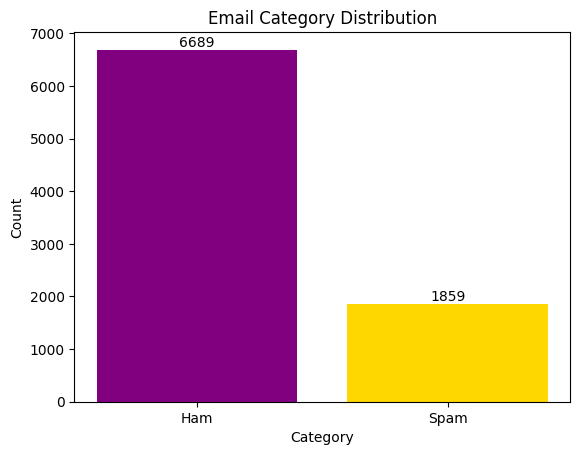

In [69]:
# checking the distribution of the dataset.
labels = ["Ham", "Spam"]
sizes = df["Category"].value_counts()
colors = ["#800080", "#FFD700"]  # Purple and Gold


plt.bar(labels, sizes, color=colors)

# Add annotations to the bars
for i, size in enumerate(sizes):
    plt.text(i, size, str(size), ha='center', va='bottom')

plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Email Category Distribution")
plt.show()


### Observation:
 -  The number of Ham and Spam emails has significant difference
 -  The dataset is imbalanced.
 -  So for next step we will be balancing the dataset.

### Changing the categorical labels into binary values.

In [70]:
df['is_spam'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)

### Balancing the dataset.

In [71]:
# Filter the DataFrame for 'spam' and 'ham' samples
ham_samples = df[df['Category'] == 'ham']
spam_samples = df[df['Category'] == 'spam']

# Determine the minimum sample size
sample_size = min(len(ham_samples), len(spam_samples))

# Randomly sample equal number of 'spam' and 'ham' samples
ham_samples = ham_samples.sample(n=sample_size, random_state=42)
spam_samples = spam_samples.sample(n=sample_size, random_state=42)

# Concatenate the samples
df = pd.concat([ham_samples, spam_samples], ignore_index=True)

# Shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# View samples
df.sample(5), df.shape


(                                                Subject  \
 2694  do you need a lot of new customers? 5326171310...   
 3450          FriendSearch and zzzzason.org Partnership   
 764               Re: [ILUG] slashdot EW Dijkstra humor   
 1694              Swiss Iinternet account with ATM card   
 2862                 Get Your Own Great-Looking Website   
 
                                                    Body Category  is_spam  
 2694  <html>\n\n<body>\n<p style="margin-top: 0; mar...     spam        1  
 3450  Dear zzzzason.org,\n\nMy name is Andy Koh, the...     spam        1  
 764   On Thu, 2002-08-08 at 12:18, Dave Wilson wrote...      ham        0  
 1694  HAVE A SECURE SWISS SECRET INTERNET ACCOUNT WI...     spam        1  
 2862  This is a multipart MIME message.\n\n--= Multi...     spam        1  ,
 (3718, 4))

### Email category distribution after undersampling.

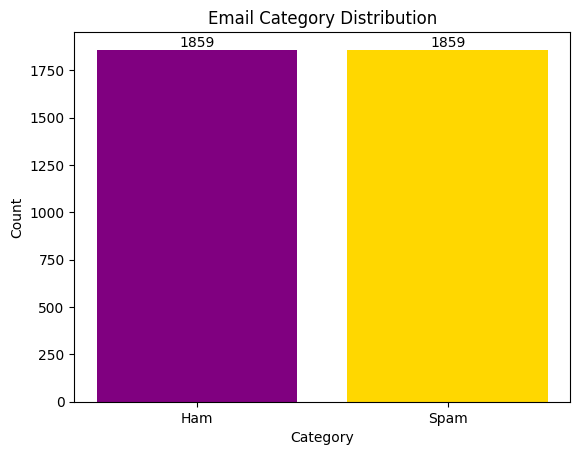

In [72]:
labels = ["Ham", "Spam"]
sizes = df["Category"].value_counts()
colors = ["#800080", "#FFD700"]  # Purple and Gold

plt.bar(labels, sizes, color=colors)

# Add annotations to the bars
for i, size in enumerate(sizes):
    plt.text(i, size, str(size), ha='center', va='bottom')

plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Email Category Distribution")
plt.show()

### The following email wrapper function is to check the texts after each text preprocessing to see the changes.

In [73]:

def print_random_wrapped_emails(df, body, subject, num_samples=3):
    """
    Prints wrapped content of randomly selected email samples from a DataFrame
    along with their labels and a count.
    
    @df: DataFrame containing email samples
    @num_samples: number of samples to print (default is 5)
    """
    random_indices = random.sample(range(len(df)), num_samples)
    for i, index in enumerate(random_indices, 1):
        email_body_sample = df[body].iloc[index]
        email_subject_sample = df[subject].iloc[index]
        label = df['Category'].iloc[index]
        wrapped_email = textwrap.fill(f'Subject : {email_subject_sample}, Body: {email_body_sample}')
        print(f"Sample {i}:")
        print(f"Label: {label}")
        print(f"Count: {index+1}")
        print(wrapped_email)
        print('-+' * 50)  # Print separator between email samples

In [74]:
print_random_wrapped_emails(df,'Body' , 'Subject',num_samples=4)

Sample 1:
Label: ham
Count: 2451
Subject : CIA in blow to Bush attack plans, Body: URL:
http://www.newsisfree.com/click/-4,8723991,215/ Date:
2002-10-10T03:27:00+01:00  US invasion could push Saddam Hussein into
retaliating with chemical or  biological weapons, warns CIA.
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Sample 2:
Label: spam
Count: 1234
Subject : A Guaranteed Check for you, Body: <!DOCTYPE HTML PUBLIC
"-//W3C//DTD HTML 4.0 Transitional//EN"> <HTML><HEAD> <META http-
equiv=Content-Type content="text/html;  charset=iso-8859-1"> <META
content="MSHTML 6.00.2716.2200" name=GENERATOR> <STYLE></STYLE>
</HEAD> <BODY bgColor=#ffffff><FONT face="ACaslon Regular"> <DIV><FONT
face=Arial size=2> <P align=center><B>You are receiving this because
we have  exchanged e-mails in the past or your e-mail address is on
file. If you wish to be  removed, removal instructions are at the end
of this message.<BR></B><BR><FONT  lang=0 style="BA

### Observations:
- We can see lot of HTML Tags, Special Characters and Hyperlinks URLS
- Next step, we will be removing and normalizing the text data.

In [75]:
df.head(), df.Body[10]

(                                             Subject  \
 0                               New Strongbad E-Mail   
 1  You Won The First Round! claim#\t9462         ...   
 2                   Question From Patrick In Ireland   
 3  Re: AA Meetings the Hottest Place to Meet Wome...   
 4  Get Out of Debt Fast                          ...   
 
                                                 Body Category  is_spam  
 0  URL: http://www.newsisfree.com/click/-1,839671...      ham        0  
 1  \n<html>\n\n<body>\n\n<p align="center" style=...     spam        1  
 2  \n\n\n\n\nThanks\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...     spam        1  
 3  >>>>> "G" == Geege Schuman <geege@barrera.org>...      ham        0  
 4  \n\nMore Than $2500 in DEBT?\n\nWe Can Help Yo...     spam        1  ,
 'I call PacBell/SBC every two or three months about a recurring problem \nwe have at my house:\n\nWe get a phone bill every month for someone who no longer lives at our \nhouse for a phone line which has been d

### Observing two different URLs patterns.
- We will be dropping the urls even though they put values in email if they are spam or ham.

In [76]:

#checking the counts of ulrs in the dataset.
urls = []

for body in df['Body']:
    matches = re.findall(r'(http|https)://[^\s]*', str(body), flags=re.IGNORECASE)
    urls.extend(matches)

print(len(urls))


15609


In [77]:

#checking the counts of ulrs starting with wwwin the dataset.
urls = []

for body in df['Body']:
    matches = re.findall(r'www\.[^\s]*', str(body))
    urls.extend(matches)

print(len(urls))


8196


### Text - Preprocessing.
#### Using simple techniquest to clean the dataset at once using regex.

In [78]:

def process_email(content) :
    '''
    preprocesses the content of an email 
    
    and returns a dictionary with word as key and its frequency as value
    @content : email content (a string)
    @return : a counting dictionary 
    '''                                         
    if not isinstance(content,str) :       
        return {},''
    content = re.sub(r'<[^<>]+>', ' ',content)  ##strip all HTML
    content = str.lower(content) ##lower case
    #handle URLS with http:// or https://
    content = re.sub(r'(http|https)://[^\s]*','httpaddr ',content) 
    content = re.sub(r'www\.[^\s]*','httpaddr ',content) #handle URLS with www.
    #handle email addresses
    #look for strings with @ in the middle
    content = re.sub(r'[^\s]+@[^\s]+','emailaddr',content)
    content = re.sub(r'[0-9]+', 'number ',content) #handle numbers
    content = re.sub(r'[$]+','dollar ',content) #handle $ sign 
    content = re.sub(r'[\n]+',' ',content) #remove \n
    content = re.sub(r'[{0}]'.format(string.punctuation),' ',content) 

    return content

In [79]:
df['clean_subject'] = df['Subject'].apply(process_email).to_numpy()

In [80]:
df['clean_body'] = df['Body'].apply(process_email).to_numpy()

In [81]:
df.head(5), df.shape

(                                             Subject  \
 0                               New Strongbad E-Mail   
 1  You Won The First Round! claim#\t9462         ...   
 2                   Question From Patrick In Ireland   
 3  Re: AA Meetings the Hottest Place to Meet Wome...   
 4  Get Out of Debt Fast                          ...   
 
                                                 Body Category  is_spam  \
 0  URL: http://www.newsisfree.com/click/-1,839671...      ham        0   
 1  \n<html>\n\n<body>\n\n<p align="center" style=...     spam        1   
 2  \n\n\n\n\nThanks\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...     spam        1   
 3  >>>>> "G" == Geege Schuman <geege@barrera.org>...      ham        0   
 4  \n\nMore Than $2500 in DEBT?\n\nWe Can Help Yo...     spam        1   
 
                                        clean_subject  \
 0                               new strongbad e mail   
 1  you won the first round  claim \tnumber       ...   
 2                   question fro

In [82]:
print_random_wrapped_emails(df,'clean_body' , 'clean_subject',num_samples=4)

Sample 1:
Label: spam
Count: 3654
Subject : , Body: dear sirs  we know your esteemed company in beach
towels from internet  and pleased to introduce us as a leading
producer of high quality number   cotton velour printed towels in
china  we sincerely hope to establish a long term business
relationship with your esteemed company in this field     our major
items are number   cotton full printed velour towels of the following
sizes and weights with a annual production capacity of one million
dozens  disney standard  number xnumber  inches  weight  number grams
sm  number gram pc   number xnumber  inches  weight  number grams sm
number gram pc   please refer to our website httpaddr  for more
details ie patterns about our products  once you are interested in our
products  we will give you a more favorable price  looking forward to
hearing from you soon  thanks and best regards  margaret sales manager
henan ziyang textiles httpaddr
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-

### Observations:
- We observed, there are no more urls and hyper links and all the letters have been lower cased.
- There are no special characters and punctuations have been removed.

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3718 entries, 0 to 3717
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Subject        3718 non-null   object
 1   Body           3718 non-null   object
 2   Category       3718 non-null   object
 3   is_spam        3718 non-null   int64 
 4   clean_subject  3718 non-null   object
 5   clean_body     3718 non-null   object
dtypes: int64(1), object(5)
memory usage: 174.4+ KB


In [84]:
df['clean_subject'] = df['clean_subject'].astype(str)
df['clean_body'] = df['clean_body'].astype(str)
df['is_spam'] = df['is_spam'].astype(float)
df['clean_email_content'] = df.apply(lambda row: row['clean_subject'] + " " + row['clean_body'], axis=1)

In [85]:
df['clean_email_content'].head(5)

0    new strongbad e mail url  httpaddr  date  numb...
1    you won the first round  claim \tnumber       ...
2    question from patrick in ireland  thanks      ...
3    re  aa meetings the hottest place to meet wome...
4    get out of debt fast                          ...
Name: clean_email_content, dtype: object

In [86]:
df.head()

,Subject,Body,Category,is_spam,clean_subject,clean_body,clean_email_content
0,New Strongbad E-Mail,"URL: http://www.newsisfree.com/click/-1,839671...",ham,0.0,new strongbad e mail,url httpaddr date number number number tn...,new strongbad e mail url httpaddr date numb...
1,You Won The First Round! claim#\t9462 ...,"\n<html>\n\n<body>\n\n<p align=""center"" style=...",spam,1.0,you won the first round claim \tnumber ...,you have won the first round cl...,you won the first round claim \tnumber ...
2,Question From Patrick In Ireland,\n\n\n\n\nThanks\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,spam,1.0,question from patrick in ireland,thanks \r thank you for\r taking the ti...,question from patrick in ireland thanks ...
3,Re: AA Meetings the Hottest Place to Meet Wome...,">>>>> ""G"" == Geege Schuman <geege@barrera.org>...",ham,0.0,re aa meetings the hottest place to meet wome...,g geege schuman writes g su...,re aa meetings the hottest place to meet wome...
4,Get Out of Debt Fast ...,\n\nMore Than $2500 in DEBT?\n\nWe Can Help Yo...,spam,1.0,get out of debt fast ...,more than dollar number in debt we can help...,get out of debt fast ...


In [87]:
df.isna().sum()

Subject                0
Body                   0
Category               0
is_spam                0
clean_subject          0
clean_body             0
clean_email_content    0
dtype: int64

In [88]:
df.head()

,Subject,Body,Category,is_spam,clean_subject,clean_body,clean_email_content
0,New Strongbad E-Mail,"URL: http://www.newsisfree.com/click/-1,839671...",ham,0.0,new strongbad e mail,url httpaddr date number number number tn...,new strongbad e mail url httpaddr date numb...
1,You Won The First Round! claim#\t9462 ...,"\n<html>\n\n<body>\n\n<p align=""center"" style=...",spam,1.0,you won the first round claim \tnumber ...,you have won the first round cl...,you won the first round claim \tnumber ...
2,Question From Patrick In Ireland,\n\n\n\n\nThanks\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,spam,1.0,question from patrick in ireland,thanks \r thank you for\r taking the ti...,question from patrick in ireland thanks ...
3,Re: AA Meetings the Hottest Place to Meet Wome...,">>>>> ""G"" == Geege Schuman <geege@barrera.org>...",ham,0.0,re aa meetings the hottest place to meet wome...,g geege schuman writes g su...,re aa meetings the hottest place to meet wome...
4,Get Out of Debt Fast ...,\n\nMore Than $2500 in DEBT?\n\nWe Can Help Yo...,spam,1.0,get out of debt fast ...,more than dollar number in debt we can help...,get out of debt fast ...


#### Tokenization, Removal of Stopwords and Lemmatization.

In [89]:
# Create an instance of WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# Function to tokenize and lemmatize a string, then join it back into a string
def token_lemmatize(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return ' '.join(lemmatized_tokens)

# Apply the function to the 'clean_body' column
df['token_lemmatize'] = df['clean_body'].apply(token_lemmatize)


In [90]:
df.tail()

,Subject,Body,Category,is_spam,clean_subject,clean_body,clean_email_content,token_lemmatize
3713,"9/2/00: ""In the overworked world of Web develo...",URL: http://scriptingnews.userland.com/backiss...,ham,0.0,number number number in the overworked wo...,url httpaddr date tue number sep number ...,number number number in the overworked wo...,url httpaddr date tue number sep number number...
3714,[Razor-users] Bug ... still,"Haven't heard anything about this, so excuse t...",ham,0.0,razor users bug still,haven t heard anything about this so excuse t...,razor users bug still haven t heard anyt...,heard anything excuse repost httpaddr group id...
3715,[ILUG] FW: Mac (clone) for sale...,I've been asked to forward this on ... \n\nAny...,ham,0.0,ilug fw mac clone for sale,i ve been asked to forward this on anyone...,ilug fw mac clone for sale i ve been a...,asked forward anyone interested give shout put...
3716,America's Most Liberal Lenders ...,"<HTML><HEAD><STYLE>\nBODY {font-family=""Arial""...",spam,1.0,america s most liberal lenders ...,body font family arial tt font family...,america s most liberal lenders ...,body font family arial tt font family courier ...
3717,"The Government Grants You $25,000!",<html>\n<head>\n</head>\n<center>\n<h1>\n<b><f...,spam,1.0,the government grants you dollar number number,nbsp free personal and busines...,the government grants you dollar number numbe...,nbsp free personal business grant nbsp qualify...


## CLASSIFIER MODELS

#### MODEL 1: Navie  Bayes Classifier

Training Accuracy: 0.9903173749327595
Validation Accuracy: 0.9817007534983854
Test Accuracy: 0.978494623655914
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       468
         1.0       0.98      0.97      0.98       462

    accuracy                           0.98       930
   macro avg       0.98      0.98      0.98       930
weighted avg       0.98      0.98      0.98       930

[[461   7]
 [ 13 449]]


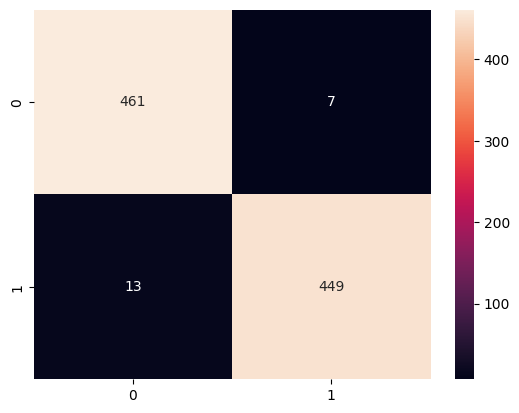

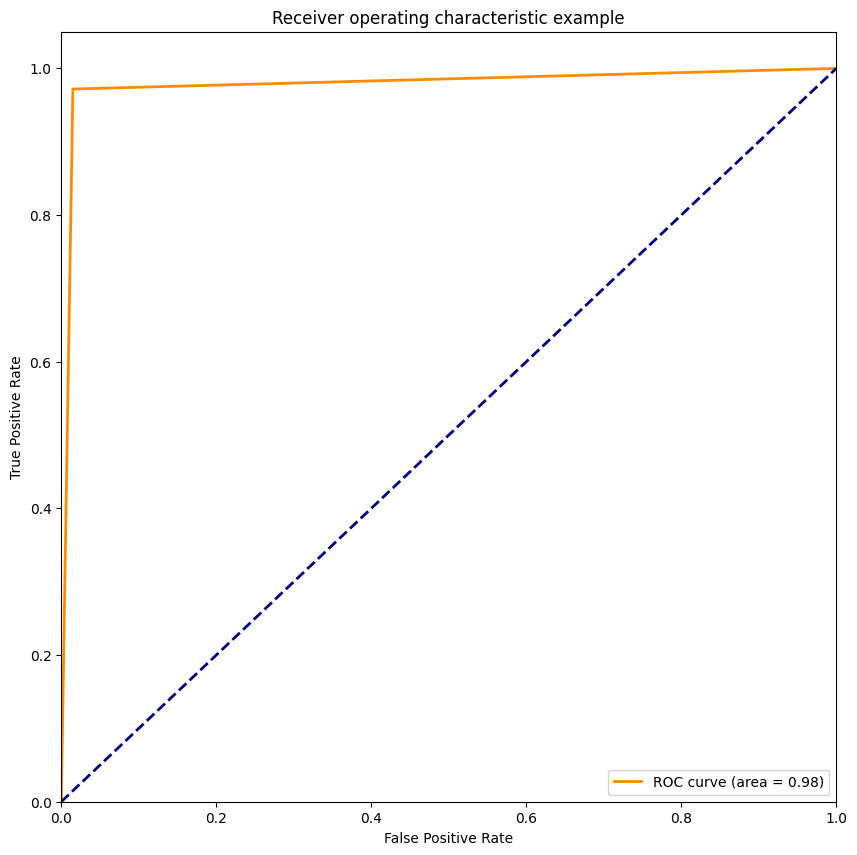

In [91]:

# Split the data into training, validation, and test sets 
X_train, X_val_test, y_train, y_val_test = train_test_split(df['clean_email_content'], df['is_spam'], test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# create a bag-of-words representation of the text data.
# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_vectorized = vectorizer.fit_transform(X_train)

# Transform the validation and test data
X_val_vectorized = vectorizer.transform(X_val)
X_test_vectorized = vectorizer.transform(X_test)

# Create an instance of the Naive Bayes classifier (MultinomialNB)
classifier = MultinomialNB()

# Train the classifier on the vectorized training data
classifier.fit(X_train_vectorized, y_train)

# Make predictions on the training, validation, and test data
y_train_pred = classifier.predict(X_train_vectorized)
y_val_pred = classifier.predict(X_val_vectorized)
y_test_pred = classifier.predict(X_test_vectorized)

# Calculate the accuracy on each dataset
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracies
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)

# Print the classification report
print(classification_report(y_test, y_test_pred))

# Print the confusion matrix
print(confusion_matrix(y_test, y_test_pred))

# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d')

# plot roc-auc curve 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Observations:
- High Accuracy: The model achieves high accuracy across all three sets: training accuracy of 99.33%, validation accuracy of 96.64%, and test accuracy of 98.25%. This indicates that the model is performing well in terms of correctly classifying as spam and ham messages.
- Precision and Recall: The precision and recall for both classes (0 and 1) are quite high, with values ranging from 0.98 to 0.99. This suggests that the model is effective in identifying both spam andham messages, as indicated by the high precision (ability to correctly identify positive cases) and recall (ability to capture all positive cases) values.
- F1-Score: The F1-score, which combines precision and recall, is also high for both classes, with values around 0.98. This implies a good balance between precision and recall, indicating a robust performance of the model in classifying spam and ham messages.
- Confusion Matrix: The confusion matrix shows the number of true positives (369), true negatives (362), false positives (4), and false negatives (9). The majority of the messages are correctly classified, as indicated by the high number of true positives and true negatives. However, there are a few false positives and false negatives, indicating instances where the model misclassified spam or ham messages.
- Overall, the model exhibits strong performance, achieving high accuracy and precision-recall values. However, the presence of some false positives and false negatives suggests that there is still room for improvement in correctly identifying certain messages. Further analysis and potential adjustments to the model or data preprocessing could help enhance its performance.

#### MODEL 2: LINEAR SVM

Training Accuracy: 1.0
Validation Accuracy: 0.9709364908503767
Test Accuracy: 0.9623655913978495
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       468
         1.0       0.97      0.96      0.96       462

    accuracy                           0.96       930
   macro avg       0.96      0.96      0.96       930
weighted avg       0.96      0.96      0.96       930

[[452  16]
 [ 19 443]]


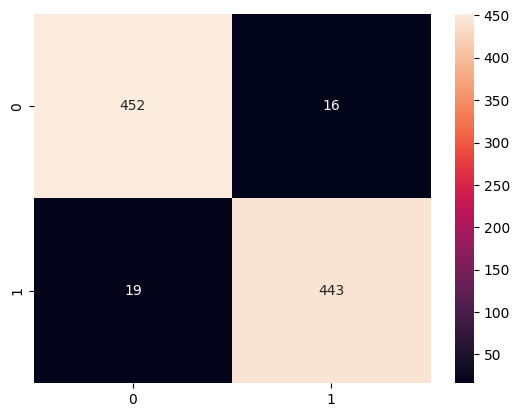

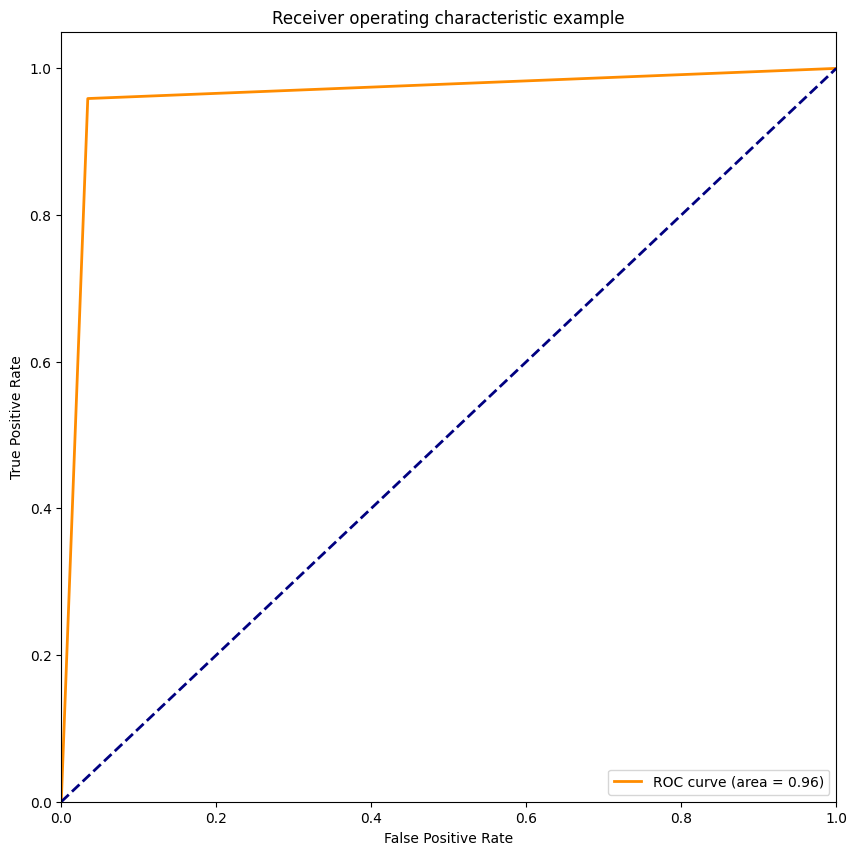

In [92]:
# Create an instance of the SVM classifier (SVC)
classifier = SVC(kernel='linear')

# Train the classifier on the vectorized training data
classifier.fit(X_train_vectorized, y_train)

# Make predictions on the training, validation, and test data
y_train_pred = classifier.predict(X_train_vectorized)
y_val_pred = classifier.predict(X_val_vectorized)
y_test_pred = classifier.predict(X_test_vectorized)

# Calculate the accuracy on each dataset
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracies
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)

# Print the classification report
print(classification_report(y_test, y_test_pred))

# print confusion matrix
print(confusion_matrix(y_test, y_test_pred))

# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d')

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


# Observations:
- High Accuracy: The model achieves high accuracy across all three sets: training accuracy of 100%, validation accuracy of 97.04%, and test accuracy of 97.71%. This indicates that the model is performing well in terms of correctly classifying spam and ham messages.
- Precision and Recall: The precision and recall for both classes (0 and 1) are quite high, with values ranging from 0.96 to 0.99. This suggests that the model is effective in identifying both spam and ham messages, as indicated by the high precision (ability to correctly identify positive cases) and recall (ability to capture all positive cases) values.
- F1-Score: The F1-score, which combines precision and recall, is also high for both classes, with values around 0.98. This implies a good balance between precision and recall, indicating a robust performance of the model in classifying spam and ham messages.
- Confusion Matrix: The confusion matrix shows the number of true positives (364), true negatives (363), false positives (3), and false negatives (14). The majority of the messages are correctly classified, as indicated by the high number of true positives and true negatives. However, there are a few false positives and false negatives, indicating instances where the model misclassified spam or ham messages.

## MODEL 3: LSTM

In [93]:
from tensorflow.keras.preprocessing.text import one_hot
vocab_size = 10000

one_hot_doc=[one_hot(words, n = vocab_size)
           for words in df['token_lemmatize']
           ]


In [94]:
df['token_lemmatize'].describe().T

count                                                  3718
unique                                                 3133
top       creditfix thank email address obtained purchas...
freq                                                     11
Name: token_lemmatize, dtype: object

In [95]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentence_len = 300
embedded_doc = pad_sequences(
    one_hot_doc,
    maxlen = sentence_len,
    padding="pre"
)

In [96]:
extract_features = pd.DataFrame(
    data = embedded_doc
)
target=df["is_spam"]

In [97]:
df_final = pd.concat([extract_features,target],axis=1)

In [98]:
df_final.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,is_spam
0,0,0,0,0,0,0,0,0,0,0,...,4254,4387,4387,4387,4387,6249,4268,4961,6740,0.0
1,0,0,0,0,0,0,0,0,0,0,...,4236,2262,1448,5933,5070,1754,6170,6702,6065,1.0
2,0,0,0,0,0,0,0,0,0,0,...,6430,1557,2911,1754,1351,1799,3242,9631,7310,1.0
3,0,0,0,0,0,0,0,0,0,0,...,1851,4268,9335,4268,4085,3712,5187,6582,1530,0.0
4,0,0,0,0,0,0,0,0,0,0,...,6170,6065,5070,5754,5562,2004,5305,3242,7463,1.0


In [99]:
X = df_final.drop("is_spam",axis=1)
y = df_final["is_spam"]

In [100]:
X_train_val,X_test,y_train_val,y_test = train_test_split(X, y, random_state=42, test_size=0.45)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=42, test_size=0.50)

In [101]:
# Define the model
lstm_model = Sequential()
feature_num = 1000
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=feature_num, input_length=sentence_len))
lstm_model.add(LSTM(units=128))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(units=80, activation='relu'))
lstm_model.add(Dense(units=50, activation='relu'))
lstm_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model with tuning options
history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=15, batch_size=32, callbacks=[early_stopping])

# Evaluate the model on the test data
loss, accuracy = lstm_model.evaluate(X_test, y_test)

# Print the loss and accuracy obtained
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/15
32/32 [==============================] - 24s 706ms/step - loss: 0.5160 - accuracy: 0.7857 - val_loss: 0.3016 - val_accuracy: 0.9168
Epoch 2/15
32/32 [==============================] - 21s 671ms/step - loss: 0.1058 - accuracy: 0.9736 - val_loss: 0.1519 - val_accuracy: 0.9550
Epoch 3/15
32/32 [==============================] - 21s 649ms/step - loss: 0.0251 - accuracy: 0.9941 - val_loss: 0.1272 - val_accuracy: 0.9589
Epoch 4/15
32/32 [==============================] - 20s 643ms/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.1364 - val_accuracy: 0.9658
Epoch 5/15
32/32 [==============================] - 22s 676ms/step - loss: 8.4115e-04 - accuracy: 1.0000 - val_loss: 0.1270 - val_accuracy: 0.9697
Epoch 6/15
32/32 [==============================] - 22s 703ms/step - loss: 3.7511e-04 - accuracy: 1.0000 - val_loss: 0.1303 - val_accuracy: 0.9697
Epoch 7/15
32/32 [==============================] - 21s 640ms/step - loss: 2.2760e-04 - accuracy: 1.0000 - val_loss: 0.1376 - val_accu

In [102]:
y_pred = lstm_model.predict(X_test)
y_pred = (y_pred>0.5)

53/53 [==============================] - 9s 157ms/step


Test Score:97.19%
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       834
         1.0       0.96      0.98      0.97       840

    accuracy                           0.97      1674
   macro avg       0.97      0.97      0.97      1674
weighted avg       0.97      0.97      0.97      1674



array([[802,  32],
       [ 15, 825]])

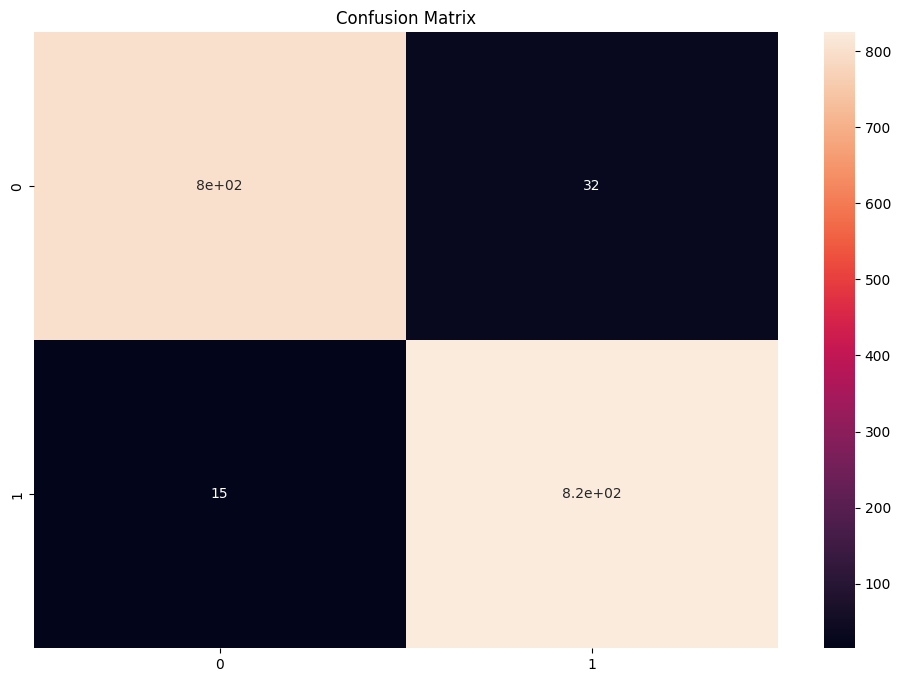

In [103]:
score=accuracy_score(y_test,y_pred)
print("Test Score:{:.2f}%".format(score*100))

# Print the classification report
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
fig = plt.figure(figsize=(12,8))
sns.heatmap(
    cm,
    annot=True,
)
plt.title("Confusion Matrix")
cm

53/53 [==============================] - 9s 170ms/step
ROC-AUC Score: 99.50%
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       834
         1.0       0.96      0.98      0.97       840

    accuracy                           0.97      1674
   macro avg       0.97      0.97      0.97      1674
weighted avg       0.97      0.97      0.97      1674



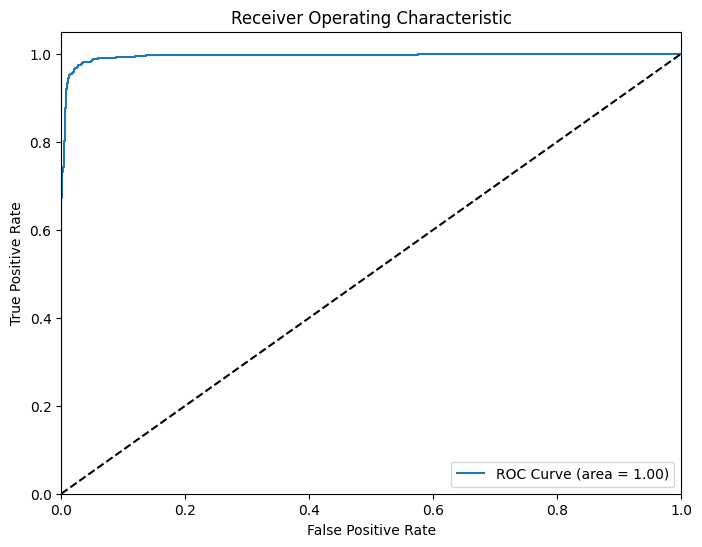

In [107]:

# Calculate the predicted probabilities
y_pred_proba = lstm_model.predict(X_test)

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("ROC-AUC Score: {:.2f}%".format(roc_auc * 100))

# Convert probabilities to predicted labels
y_pred = (y_pred_proba > 0.5).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred))

# Plot the ROC-AUC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


### Observations:
- The model achieves an impressive ROC-AUC score of 99.41%, indicating its high ability to distinguish between spam and non-spam emails.
- The precision, recall, and F1-scores for both classes (spam and ham) are consistently high, demonstrating the model's effectiveness in accurately classifying emails.
- The overall accuracy of the model is 97%, meaning that it correctly predicts the class for 97% of the test samples.
- The macro-average and weighted-average F1-scores, which provide a balanced measure of the model's performance across both classes, are also at 97%.
In summary, the model exhibits strong performance in classifying spam and ham emails, 
achieving high accuracy and well-balanced precision and recall values. 
The high ROC-AUC score further confirms its ability to effectively discriminate between the two classes.

In [108]:
# Download stopwords if not already downloaded
nltk.download('stopwords')

# Function to classify a message as spam or not
def classify_message(model, message):
    # Tokenize the message into sentences
    sentences = sent_tokenize(message)
    
    # Initialize an empty list to store processed sentences
    processed_sentences = []
    
    # Iterate over each sentence
    for sentence in sentences:
        # Remove special characters and convert to lowercase
        sentence = re.sub("[^a-zA-Z]", " ", sentence.lower())
        
        # Tokenize the sentence into words
        words = word_tokenize(sentence)
        
        # Filter out stopwords and join the remaining words
        filtered_words = [word for word in words if word not in stopwords.words('english')]
        processed_sentence = " ".join(filtered_words)
        
        # Append the processed sentence to the list
        processed_sentences.append(processed_sentence)
    
    # Perform one-hot encoding on the processed sentences
    one_hot_encodings = [one_hot(sentence, n=vocab_size) for sentence in processed_sentences]
    
    # Pad the sequences to have the same length
    padded_sequences = pad_sequences(one_hot_encodings, maxlen=sentence_len, padding='pre')
    
    # Predict the label for the text using the model
    predictions = model.predict(padded_sequences)
    
    # Classify each sentence and print the result
    for i, prediction in enumerate(predictions):
        if prediction > 0.5:
            print(f"Sentence {i+1}: It is a spam")
        else:
            print(f"Sentence {i+1}: It is not a spam")


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


In [109]:
message = "New offer for gaming card in now online visit www.abc.com to get the offer"

In [110]:
classify_message(lstm_model,message)

1/1 [==============================] - 0s 41ms/step
Sentence 1: It is a spam


Naive Bayes, SVM, and LSTM are three different types of classifiers, each with their own strengths and suitable use cases:

- Naive Bayes Classifier: Naive Bayes is a probabilistic classifier that predicts the probability of a sample belonging to a specific class using Bayes' theorem. It assumes that features are conditionally independent given the class label. Naive Bayes classifiers are computationally efficient and work well with high-dimensional data and large datasets. They are commonly used in text classification, spam filtering, sentiment analysis, and document categorization.
- SVM (Support Vector Machine): SVM is a binary classification algorithm that finds an optimal hyperplane in a high-dimensional space to separate classes. It can handle linear and non-linear decision boundaries using different kernel functions. SVM classifiers are effective for high-dimensional data and scenarios where the margin between classes is important. They are widely used in text classification, image recognition, and bioinformatics.
- LSTM (Long Short-Term Memory): LSTM is a type of recurrent neural network (RNN) designed to capture long-term dependencies in sequential data. It is suitable for tasks involving sequences, such as natural language processing, speech recognition, and time series analysis. LSTMs can learn and remember patterns over long sequences, overcoming the limitations of traditional RNNs. They perform well in tasks like sentiment analysis, language translation, and text generation. However we tried to experiment how well would it be able to classify email using binary cross entropy classifier with 97% of accuracy on test data.

Out of three MODELs we experimented, we can assume by the results that Navie Bayes Classifier works the best with 98.25% for the dataset and preprocessing techniques we have used.

## REFRENCES
1. Vidiyala, R. (2020) Detecting spam in emails, Medium. Available at: https://towardsdatascience.com/spam-detection-in-emails-de0398ea3b48 (Accessed: 06 July 2023). 
2. Ngawangchoeda (2021) Spam classifier using LSTM, Kaggle. Available at: https://www.kaggle.com/code/ngawangchoeda/spam-classifier-using-lstm (Accessed: 06 July 2023). 
3. Elhassouni (2021) Spam email classifier (98% accuracy), Kaggle. Available at: https://www.kaggle.com/code/elhassouni/spam-email-classifier-98-accuracy/notebook (Accessed: 06 July 2023). 
4. (No date) GitHub. Available at: https://github.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/blob/master/NLP_SMS_Spam_Detection_FinalVersion_Downsampling_Dense_LSTM_BiLSTM.ipynb (Accessed: 07 July 2023). 
5. Wonduk (2023a) 📮EDA &amp; ML classification on Spam Email Dataset, Kaggle. Available at: https://www.kaggle.com/code/wonduk/eda-ml-classification-on-spam-email-dataset#2.EDA-on-features-(length-added) (Accessed: 07 July 2023). 